<a href="https://colab.research.google.com/github/kkmax-develop/FruitDiscrimination/blob/master/Transfer_Learning_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# GPUが割り当てられているかチェック
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

### **ライブラリのインポート**

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt

#画像認識関連ライブラリ
import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Input, Activation, add, Add, Dropout, BatchNormalization, Reshape,GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras import optimizers

#ResNet50
from keras.applications.resnet50 import ResNet50

In [23]:
# 定数定義
batch_size = 16
IMG_WIDTH = 100
IMG_HEIGHT = 100
CHANNELS = 3
CLASSES = 39
train_dir = "/content/drive/My Drive/Colab Notebooks/FruitDiscrimination/data/training"
validation_dir = "/content/drive/My Drive/Colab Notebooks/FruitDiscrimination/data/test"
TARGET = [
          "Apple Braeburn","Apple Crimson Snow","Apple Golden 1","Apple Golden 2","Apple Golden 3","Apple Granny Smith","Apple Pink Lady","Apple Red 1","Apple Red 2","Apple Red 3","Apple Red Delicious"
          "Apple Red Yellow 1","Apple Red Yellow 2","Pear",	"Pear 2",	"Pear Abate",	"Pear Forelle",	"Pear Kaiser",	"Pear Monster",	"Pear Red",	"Pear Stone",	"Pear Williams","Mandarine","Strawberry",
          "Strawberry Wedge","Grape Blue",	"Grape Pink",	"Grape White",	"Grape White 2",	"Grape White 3",	"Grape White 4","Peach","Peach 2","Peach Flat","Cherry 1",	"Cherry 2",	"Cherry Rainier",	
          "Cherry Wax Black",	"Cherry Wax Red",	"Cherry Wax Yellow"
         ]

### **データの前処理**

ImageDataGeneratorクラスのインスタンスを作成。各引数の意味は公式ドキュメントを参照。

https://keras.io/ja/preprocessing/image/

In [24]:
# データ拡張の定義
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True
    )

In [25]:
# ImageDataGeneratorを使用してデータの読み込みと拡張
train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(IMG_WIDTH,IMG_HEIGHT),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True,
            classes=TARGET
        )

Found 20765 images belonging to 39 classes.


In [26]:
# validationの定義。データ拡張は行わず、正規化のみ実施。
validation_datagen = image.ImageDataGenerator(rescale=1.0 / 255)

In [27]:
# validationデータの読み込み
validation_generator = validation_datagen.flow_from_directory(
            validation_dir,
            target_size=(IMG_WIDTH,IMG_HEIGHT),
            batch_size=batch_size,
            class_mode='categorical',
            classes=TARGET
        )

Found 6938 images belonging to 39 classes.


### **モデル作成**

In [28]:
# ImageNetで学習したResNet50の読み込み
model_ResNet50 = ResNet50(weights='imagenet',
                     include_top=False,
                     input_shape=(IMG_WIDTH,IMG_HEIGHT,CHANNELS))

# 全結合層の追加
model = Sequential()
model.add(model_ResNet50)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dense(CLASSES,activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_5 (Dense)              (None, 39)                20007     
Total params: 24,656,807
Trainable params: 24,603,687
Non-trainable params: 53,120
_________________________________________________________________


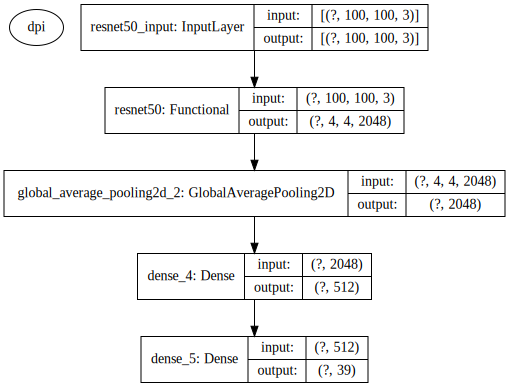

In [29]:
# 作成したモデルの可視化
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, dpi=None).create(prog='dot', format='svg'))

### **学習**

In [30]:
# モデルの学習方法について指定
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
 
STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n  // validation_generator.batch_size



epochs = 5

# 学習 
result = model.fit_generator(train_generator,
                             steps_per_epoch=STEP_SIZE_TRAIN,
                             epochs=epochs,
                             validation_data=validation_generator,
                             validation_steps=STEP_SIZE_VALID)


Epoch 1/5
 283/1297 [=====>........................] - ETA: 2:29:45 - loss: 2.0654 - accuracy: 0.5844

KeyboardInterrupt: ignored

In [ ]:
result.history.keys()

### **学習状況の可視化**

In [ ]:
plt.style.use('fivethirtyeight')
plt.title('Model Accuracy')
plt.plot(range(1, epochs+1), result.history['accuracy'], label="training")
plt.plot(range(1, epochs+1), result.history['val_accuracy'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.style.use('fivethirtyeight')
plt.title('Model Loss')
plt.plot(range(1, epochs+1), result.history['loss'], label="training")
plt.plot(range(1, epochs+1), result.history['val_loss'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### **モデルの保存**

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/FruitDiscrimination/model/ResNet50_Transfer.h5') 
